In [54]:
# PACKAGES
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os
import scipy
import pandas as pd
%matplotlib inline
import seaborn as  sns
from itertools import chain, combinations
from scipy import stats

In [55]:
path_to_ROSMAP_subsets_CV_results = "../../Pipeline_Outputs_Submitted/origGE/results/MTL/ROSMAP_CV_subsets_results.csv"

In [56]:
cmap=plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N)]
light_phenotype_colors = {"CERAD": cmaplist[3], "PLAQUES": cmaplist[7],  "ABETA_IHC": cmaplist[11], 
                    "BRAAK": cmaplist[5], "TANGLES": cmaplist[1], "TAU_IHC": cmaplist[9]}

phenotype_colors = {"CERAD": cmaplist[2], "PLAQUES": cmaplist[6],  "ABETA_IHC": cmaplist[10], 
                    "BRAAK": cmaplist[4], "TANGLES": cmaplist[0], "TAU_IHC": cmaplist[8]}

In [57]:
df= pd.read_csv(path_to_ROSMAP_subsets_CV_results)
df = df.drop("Fold",axis=1).replace(0, np.nan)

In [58]:
dset_avail = {"A": np.array(["CERAD", "ABETA_IHC", "BRAAK", "TAU_IHC"]), 
             "M": np.array(["CERAD", "PLAQUES", "BRAAK"]),
             "R": np.array(["CERAD", "PLAQUES",  "ABETA_IHC", "BRAAK", "TANGLES", "TAU_IHC"])}

In [59]:
# M should actually be 879, but its the same as A+R, so i changed it for plotting purposes
dset_sizes = {"A": 337, "M": 870, "R": 550}

In [60]:

def powerset(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]


subset_sizes = {}
subset_variables = {}

for subset in list(powerset(dset_sizes.keys())):
    subset_name = "".join(subset)
    subset_variables[subset_name] = np.array([])
    subset_sizes[subset_name] = 0
    for elt in subset:
        subset_variables[subset_name] = np.union1d(subset_variables[subset_name], dset_avail[elt])
        subset_sizes[subset_name] += dset_sizes[elt]

    

In [61]:
grouped_means = df.groupby(['Phenotype', "Subset"]).mean()
means = pd.DataFrame(grouped_means.to_records(), columns=["Phenotype", "Subset", "Val"])

grouped_sems = df.groupby(['Phenotype', 'Subset']).sem()
sems = pd.DataFrame(grouped_sems.to_records(), columns=["Phenotype", "Subset", "Val"])

In [62]:
means["Sizes"] = means["Subset"].apply(lambda x: subset_sizes[x])
means["Colors"] = means["Phenotype"].apply(lambda x: phenotype_colors[x])
means["Light_Colors"] = means["Phenotype"].apply(lambda x: light_phenotype_colors[x])

means["Shape"] = means["Subset"].apply(lambda x: "D" if "R" in x else "o")

In [63]:
means_1 = means[means["Phenotype"].isin(["CERAD", "PLAQUES", "ABETA_IHC"])]
means_2 = means[means["Phenotype"].isin(["BRAAK", "TANGLES", "TAU_IHC"])]

In [64]:
def get_num_labels(row):
    dsets_w_phen = np.array([k for k in dset_avail.keys() if row["Phenotype"] in dset_avail[k]])
    training_dsets_w_phen = np.intersect1d(list(row["Subset"]), dsets_w_phen)
    num_labels = 0
    for dset in training_dsets_w_phen:
        num_labels += dset_sizes[dset]
    return num_labels

means_1["num_labels"] = 0
for i,row in means_1.iterrows():
    means_1.loc[i, "num_labels"] = get_num_labels(row)

means_2["num_labels"] = 0 
for i,row in means_2.iterrows():
    means_2.loc[i, "num_labels"] = get_num_labels(row)

    
means_1["Light_Colors"] = "#cccccc"
means_2["Light_Colors"] = "#cccccc"

/home/nbbwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/nbbwang/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/nbbwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

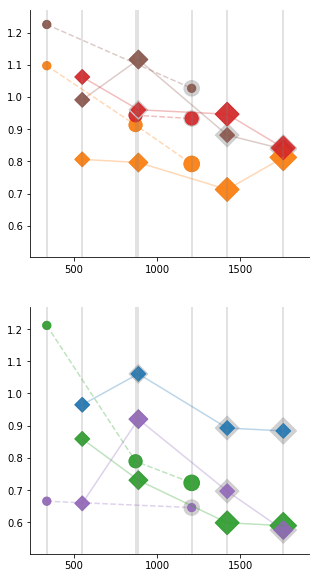

In [65]:
f,axs = plt.subplots(2,1, figsize=(5,10), sharey=True)
for ax_id,toplot in enumerate([means_1, means_2]):

    for x in toplot["Sizes"].unique():
        axs[ax_id].axvline(x, alpha=.3, color="gray")
        
    for i,subdf in toplot.groupby(["Phenotype", "Shape"]):
        temp = subdf.sort_values("Sizes")
        temp = temp.dropna()
        if subdf["Shape"].values[0] == "o":
            ls = "--"
        else: 
            ls = "-"
            
        if len(temp)>0:
            axs[ax_id].plot(temp["Sizes"], temp["Val"], c=temp["Colors"].values[0], alpha=.3, ls=ls)
    
    for markertype in toplot["Shape"].unique():
        subdf = toplot[toplot["Shape"]==markertype]
        axs[ax_id].scatter(subdf["Sizes"], subdf["Val"], c=subdf["Light_Colors"], marker=markertype, s=subdf["Sizes"]/5, alpha=.9)#, edgecolors=subdf["Colors"])
        axs[ax_id].scatter(subdf["Sizes"], subdf["Val"], c=subdf["Colors"], marker=markertype, s=subdf["num_labels"]/5, alpha=.9)

    axs[ax_id].spines['right'].set_visible(False)
    axs[ax_id].spines['top'].set_visible(False)
    axs[ax_id].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[ax_id].set_facecolor("None")



## Sourcedata

In [66]:
sourcedata= pd.read_csv(path_to_ROSMAP_subsets_CV_results)
sourcedata = sourcedata.replace(0, np.nan)
sourcedata["Fold"] = sourcedata["Fold"] - 24
# sourcedata.to_csv("sourcedata/2b_cv_rosmap_subsets.csv", index=False)

In [67]:
dset_order = ["A", "R", "M", "AR", "AM", "MR", "AMR"]

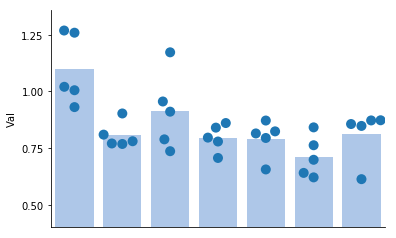

CERAD
A,R,M,AR,AM,MR
*,-,-,-,-,-


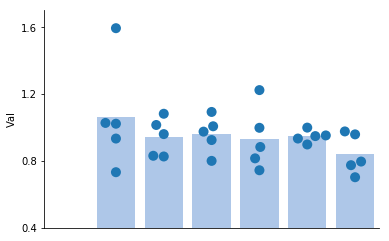

PLAQUES
A,R,M,AR,AM,MR
-,-,-,*,-,-


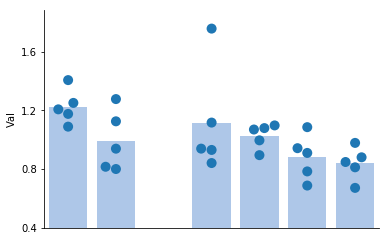

ABETA_IHC
A,R,M,AR,AM,MR
*,-,-,-,**,-


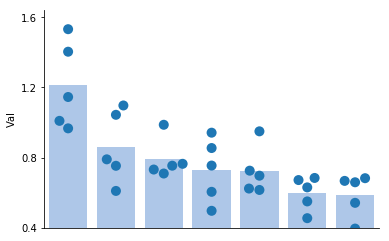

BRAAK
A,R,M,AR,AM,MR
**,*,-,**,-,-


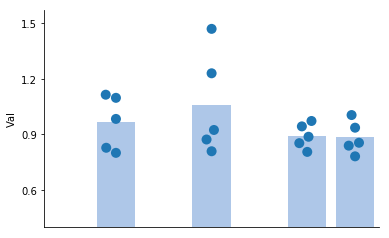

TANGLES
A,R,M,AR,AM,MR
-,-,-,-,-,-


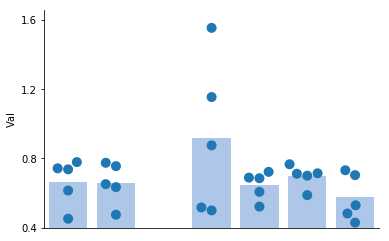

TAU_IHC
A,R,M,AR,AM,MR
-,-,-,-,-,-


In [68]:
for phen in sourcedata["Phenotype"].unique():
    
    f, ax = plt.subplots(1,1,figsize=(6,4))


    g= sns.catplot(kind="bar", data=sourcedata[sourcedata["Phenotype"]==phen], x="Subset", y="Val", 
                order=dset_order, color=cmaplist[1], 
                  ax=ax, ci=None, alpha=1, dodge=False, saturation=1)

    g= sns.catplot(data=sourcedata[sourcedata["Phenotype"]==phen], x="Subset", y="Val", 
                order=dset_order, color=cmaplist[0], kind="swarm", aspect=1, ax=ax, s=10)

#     ax.get_legend().remove()

    ax.grid(False)
    # Show graphic
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_facecolor("None")

    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True, color="#000000")
    
    ax.set_ylim(.4)
    ax.set_xticklabels("")
    ax.axes.get_xaxis().set_visible(False)
    
    plt.close(2)
    plt.close(3)
    plt.show()
    

    tmp = sourcedata[sourcedata["Phenotype"]==phen]
    annots = []
    for dset in dset_order[:-1]:
        t,p = stats.ttest_rel(-1*np.log10(tmp[tmp["Subset"]=="AMR"]["Val"]), 
                              -1*np.log10(tmp[tmp["Subset"]==dset]["Val"]))
        annots.append("***" if p < .001 else "**" if p < .01 else "*" if p < .05 else "-")
    print(phen)
    print(",".join(dset_order[:-1]))
    print(",".join(annots))
   
   